<a href="https://colab.research.google.com/github/lszam/fabrizio-mars/blob/main/fab_mars_grav_saida_qgis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Editor: Luizemara Szameitat     
Ver.2 16-04-2025*

In [ ]:
!pip install rasterio verde -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.6/186.6 kB 13.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.transform import from_bounds
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS

import verde as vd

Download dos dados gravimétricos Bouguer

In [ ]:
# data repository https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/mrors_1xxx/data/rsdmap/

!wget https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/mrors_1xxx/data/rsdmap/ggmro_120_bouguer_90.img
!wget https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/mrors_1xxx/data/rsdmap/ggmro_120_bouguer_90.lbl


--2025-04-17 00:11:12--  https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/mrors_1xxx/data/rsdmap/ggmro_120_bouguer_90.img
Resolving pds-geosciences.wustl.edu (pds-geosciences.wustl.edu)... 128.252.144.141
Connecting to pds-geosciences.wustl.edu (pds-geosciences.wustl.edu)|128.252.144.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132710400 (127M) [application/octet-stream]
Saving to: ‘ggmro_120_bouguer_90.img’

ggmro_120_bouguer_9 100%[===================>] 126.56M  1.49MB/s    in 88s     

2025-04-17 00:12:40 (1.44 MB/s) - ‘ggmro_120_bouguer_90.img’ saved [132710400/132710400]

--2025-04-17 00:12:40--  https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/mrors_1xxx/data/rsdmap/ggmro_120_bouguer_90.lbl
Resolving pds-geosciences.wustl.edu (pds-geosciences.wustl.edu)... 128.252.144.141
Connecting to pds-geosciences.wustl.edu (pds-geosciences.wustl.edu)|128.252.144.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3666

**PDS3 (Planetary Data System, versão 3)**: padrão de empacotamento e descrição de dados científicos de missões planetárias mantido pela NASA

**Arquivo .lbl**: Arquivo metadados contendo todas as informações necessárias para formar o sistema de coordenadas

MAP_PROJECTION_TYPE         = “EQUIRECTANGULAR”
TARGET_NAME                 = “MARS”
EQUATOR_RADIUS              = 3396190.0  <m>
POLAR_RADIUS                = 3376200.0  <m>
WESTERNMOST_LONGITUDE       = 0.0        <deg>
EASTERNMOST_LONGITUDE       = 360.0      <deg>
MAXIMUM_LATITUDE            = 90.0       <deg>
MINIMUM_LATITUDE            = –90.0      <deg>
MAP_RESOLUTION              = 16         <pix/deg>


Exibir dados em mapa

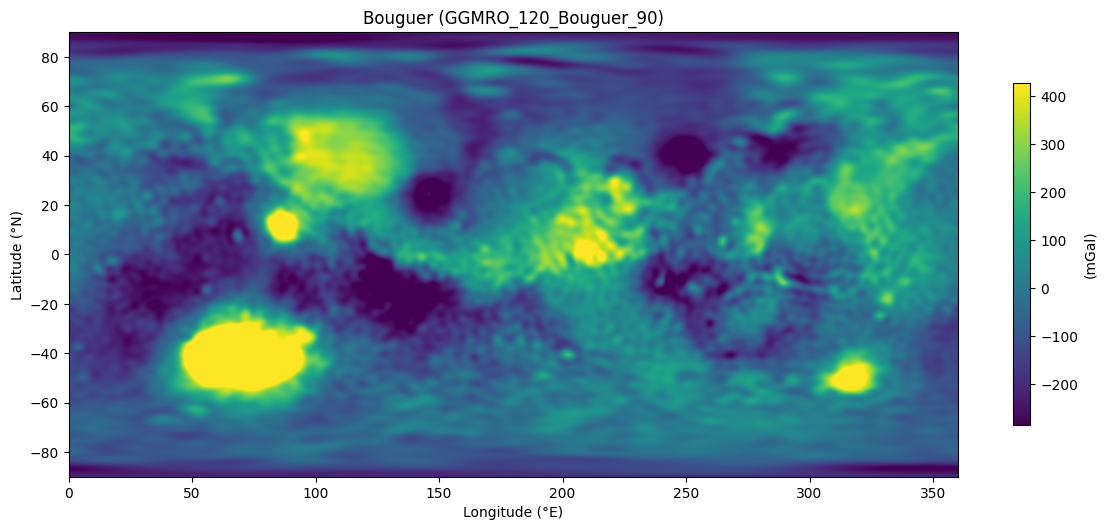

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Configurações baseadas no .lbl
lines = 2880
samples = 5760
dtype = '<f8'  # floats de 64 bits little-endian
img_path = 'ggmro_120_bouguer_90.img'

# Carregar os dados
data = np.fromfile(img_path, dtype=dtype).reshape((lines, samples))

# Substituir valores inválidos por NaN
data = np.where(np.isfinite(data), data, np.nan)

# Definir limites de exibição usando percentis para melhor contraste
vmin, vmax = np.nanpercentile(data, [2, 98])

# Exibir o mapa com normalização de contraste
plt.figure(figsize=(12, 6))
extent = [0, 360, -90, 90]  # Longitude de 0 a 360, latitude de -90 a +90
img = plt.imshow(data, origin='upper', extent=extent, vmin=vmin, vmax=vmax)
plt.colorbar(img, label='(mGal)', shrink = 0.6)
plt.title('Bouguer (GGMRO_120_Bouguer_90)')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.tight_layout()
plt.show()

# Salvar GeoTIFF reprojetado
import rasterio
from rasterio.transform import from_bounds

transform = from_bounds(0, -90, 360, 90, samples, lines)
with rasterio.open('bouguer_mars_latlong_epsg49900.tif', 'w',
                   driver='GTiff', height=lines, width=samples,
                   count=1, dtype=data.dtype,
                   transform=transform) as dst:
    dst.write(data, 1)

Mudar longitudes para -180 a +180

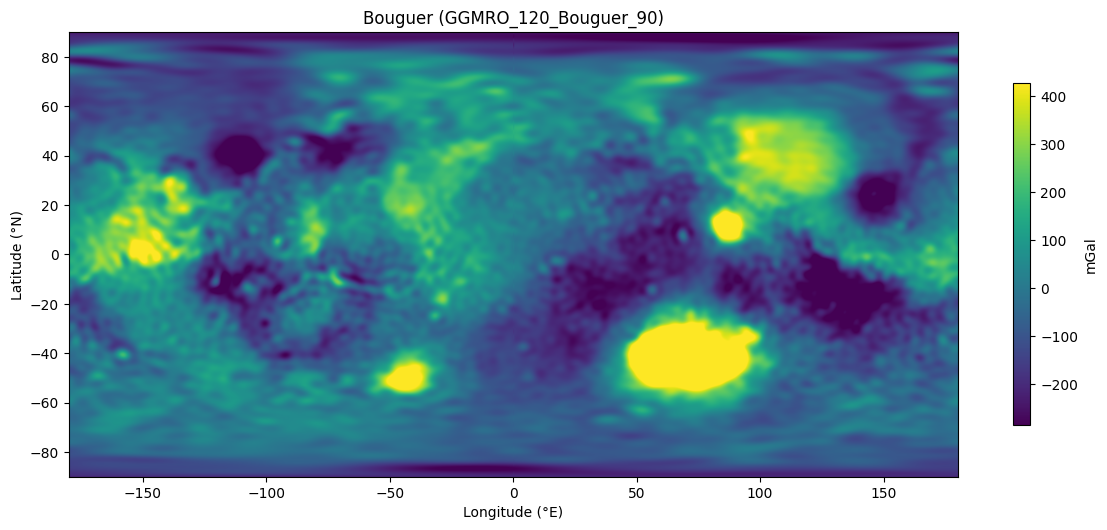

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_bounds

# Parâmetros vindos do arquivo .lbl
lines = 2880
samples = 5760
dtype = '<f8'
img_path = 'ggmro_120_bouguer_90.img'

# Carrega e limpa os dados
data = np.fromfile(img_path, dtype=dtype).reshape((lines, samples))
data = np.where(np.isfinite(data), data, np.nan)

# "Rotaciona" 180° de longitude: desloca todas as colunas samples//2
#    (-samples//2 porque queremos que a coluna original 180° vire a nova coluna 0)
data_shifted = np.roll(data, shift=-samples//2, axis=1)

vmin, vmax = np.nanpercentile(data_shifted, [2, 98])
plt.figure(figsize=(12, 6))
extent = [-180, 180, -90, 90]
img = plt.imshow(data_shifted, origin='upper', extent=extent,
                 vmin=vmin, vmax=vmax)
plt.colorbar(img, label='mGal', shrink=0.6)
plt.title('Bouguer (GGMRO_120_Bouguer_90)')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')
plt.tight_layout()
plt.show()

# Salvar GeoTIFF com coordenadas shiftadas
transform = from_bounds(-180, -90, 180, 90, samples, lines)
with rasterio.open(
    'bouguer_mars_latlon_-180_180.tif', 'w',
    driver='GTiff', height=lines, width=samples,
    count=1, dtype=data_shifted.dtype,
    transform=transform
) as dst:
    dst.write(data_shifted, 1)
